## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [ ]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10

%matplotlib inline

In [ ]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


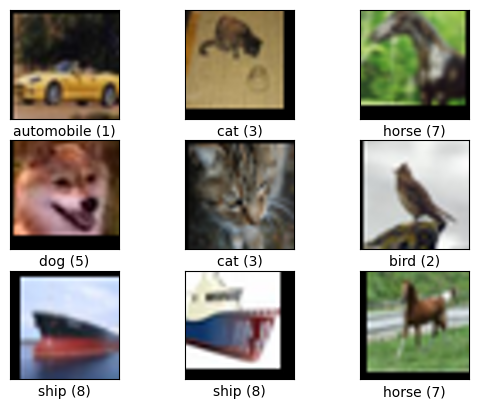

In [ ]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed=1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms for validation (no augmentation)
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    # Define the transform for training (and data augmentation)

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images if requested
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = next(data_iter)
        # Unnormalize the images for display
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        unnorm_images = [unnormalize(img, mean, std) for img in images]
        X = torch.stack(unnorm_images).numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

def unnormalize(img, mean, std):
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return img

trainloader, valloader = get_train_valid_loader()

# Convolutional Neural Network Architecture

Please first review the CNN lecture and problem statement pdf to understand the overall architecture of a CNN and how each dimension evolves after each layer, we'll take as example the first and famous CNN LeNet5 :
<figure align="center">
  <img src="https://doimages.nyc3.cdn.digitaloceanspaces.com/010AI-ML/content/images/2021/10/image-17.png" alt="LeNet5 Architecture" width="600">
  <figcaption>Image credit: <a href="https://en.wikipedia.org">Wikipedia</a></figcaption>
</figure>

# **Theory - Part 1 (20%)**

Please answer the following questions to assess your understanding of what happens during the training and inference of a CNN.

If you find any of these questions challenging or have any doubts, feel free to ask a TA for guidance or hints on the solution.

## 1. First Layer Convolution

If we consider the input of LeNet5 to be CIFAR-10, what would be the shape of the parameters of the first convolutional layer (stride = 1)?

- **A.** `torch.Size([6, 1, 5, 5])`
- **B.** `torch.Size([6, 3, 3, 3])`
- **C.** `torch.Size([6, 1, 5, 5])`
- **D.** `torch.Size([6, 3, 5, 5])`

## Ans1: D

## 2. Subsampling Window

What is the shape of the subsampling window (stride = 2) for the second layer (between C1 and C2), and does this shape remain invariant regardless of the subsampling method (e.g., Avg pooling or Max pooling)?

- **A.** `2x2, yes it does`
- **B.** `3x3, no it doesn't`
- **C.** `2x2, no it doesn't`
- **D.** `yes, it does`


## Ans2: A

## 3. Backpropagation for Convolutional Filters

Do the filters in the convolutional layers also benefit from backpropagation?

## Ans3: Yes

## 4. Role of the Fully-Connected Layer

Explain in your own words why it is necessary to have a fully-connected layer in the architecture.


## Ans4:
The fully connected layer is necessary to combine the features extracted by the convolutional layers and to make the final decision about the class of the input image.

# **Coding(60%)**

## Build your own Convolutional Neural Network Architecture

## Different ways to improve the accuracy of your network :
- Change the number of convolutions and layers (you can take inspiration from internet as you as you cite the architecture)
- Change the optmizer / its hyperparameters
- Add new types of layers
- Do some data augmentation in the get_train_valid_loader function (flipped, cropped, uncentered images) cf. https://pytorch.org/vision/stable/transforms.html


In [ ]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################

        ## Inspired from https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy

        self.conv1 = nn.Conv2d(n_input_channels, 32, kernel_size=3, padding=1)
        self.bnn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bnn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bnn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bnn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bnn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bnn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, n_output)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        '''
        '''
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Tensor `x` with `x.view`.                                                    #
        ###############################################################################

        '''
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        output = self.logsoftmax(x)
        return output

        '''
        x = F.relu(self.conv1(x))
        x = self.bnn1(x)
        x = F.relu(self.conv2(x))
        x = self.bnn2(x)
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.bnn3(x)
        x = F.relu(self.conv4(x))
        x = self.bnn4(x)
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = self.bnn5(x)
        x = F.relu(self.conv6(x))
        x = self.bnn6(x)
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        return x

    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

In [ ]:
import torch.optim


net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

epochs = 6
steps = 0
running_loss = 0
print_every = 20
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):

        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        #                                                                              #
        ################################################################################
        output = net(images)
        targets = labels
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        loss = criterion(output, targets)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        running_loss += loss.item()

        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(valloader):

                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                output = net(images)
                accuracy += torch.sum(torch.argmax(output, dim=1) == labels).item()
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################

            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test accuracy: {:.4f}..".format(accuracy/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            running_loss = 0
            start = time.time()

Epoch: 1/6.. Loss: 2.0959.. Test accuracy: 20.2500.. 0.2690 s/batch
Epoch: 1/6.. Loss: 1.8326.. Test accuracy: 23.3125.. 0.2285 s/batch
Epoch: 1/6.. Loss: 1.6907.. Test accuracy: 23.5625.. 0.2615 s/batch
Epoch: 1/6.. Loss: 1.6923.. Test accuracy: 25.7500.. 0.2293 s/batch
Epoch: 1/6.. Loss: 1.6324.. Test accuracy: 25.6875.. 0.2716 s/batch
Epoch: 1/6.. Loss: 1.6004.. Test accuracy: 23.7500.. 0.2287 s/batch
Epoch: 1/6.. Loss: 1.5524.. Test accuracy: 29.1875.. 0.2659 s/batch
Epoch: 1/6.. Loss: 1.5464.. Test accuracy: 28.6250.. 0.2274 s/batch
Epoch: 1/6.. Loss: 1.4556.. Test accuracy: 29.0000.. 0.2672 s/batch
Epoch: 1/6.. Loss: 1.5245.. Test accuracy: 31.8750.. 0.2617 s/batch
Epoch: 1/6.. Loss: 1.4187.. Test accuracy: 31.1875.. 0.2284 s/batch
Epoch: 1/6.. Loss: 1.3812.. Test accuracy: 31.8125.. 0.2718 s/batch
Epoch: 1/6.. Loss: 1.3690.. Test accuracy: 33.0625.. 0.2313 s/batch
Epoch: 1/6.. Loss: 1.3931.. Test accuracy: 34.0625.. 0.2761 s/batch
Epoch: 1/6.. Loss: 1.3616.. Test accuracy: 34.31

Save best trained model.

In [ ]:
## You should be familiar with how to save a pytorch model (Make sure to save the model in your Drive)
torch.save(net.state_dict(), './conv_net.pth')

# Some visualisations and Interpretation questions
This code allows us to look at the filters of the first layer of convolution :

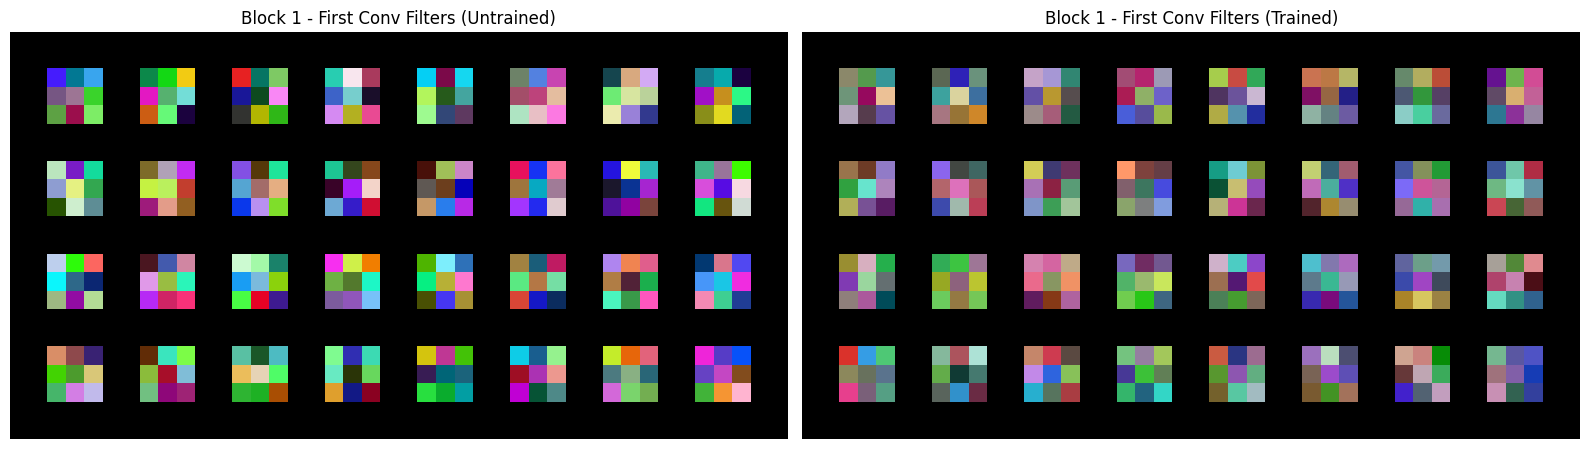

In [ ]:
def visualize_filters(layer, title='Filters'):
    filters = layer.weight.data.clone().cpu()
    filters = (filters - filters.min()) / (filters.max() - filters.min())
    grid = vutils.make_grid(filters, nrow=8, padding=2)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

model = ConvNet()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Untrained filters ---
filters_untrained = model.conv1.weight.data.clone().cpu()
filters_untrained = (filters_untrained - filters_untrained.min()) / (filters_untrained.max() - filters_untrained.min())
grid_untrained = vutils.make_grid(filters_untrained, nrow=8, padding=2)
axes[0].imshow(grid_untrained.permute(1, 2, 0))
axes[0].set_title("Block 1 - First Conv Filters (Untrained)")
axes[0].axis("off")

# --- Trained filters ---
filters_trained = net.conv1.weight.data.clone().cpu()
filters_trained = (filters_trained - filters_trained.min()) / (filters_trained.max() - filters_trained.min())
grid_trained = vutils.make_grid(filters_trained, nrow=8, padding=2)
axes[1].imshow(grid_trained.permute(1, 2, 0))
axes[1].set_title("Block 1 - First Conv Filters (Trained)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

#### What do you notice about the filters after the training ? Try to fin an interpretation about it.

**Answer:** The trained filters appear dimmer than the initial filters. This is because the filters are learned during training, and the initial filters are random. The trained filters are more specialized to detect certain features in the images typically edges, corners, etc which correspond to darker regions in the filters.


### Activation maps
This code snippet uses a forward hook to capture the output of the first convolutional layer of a CNN when a sample image is passed through it. The resulting activation maps show how each filter in the layer responds to different regions or features in the image.

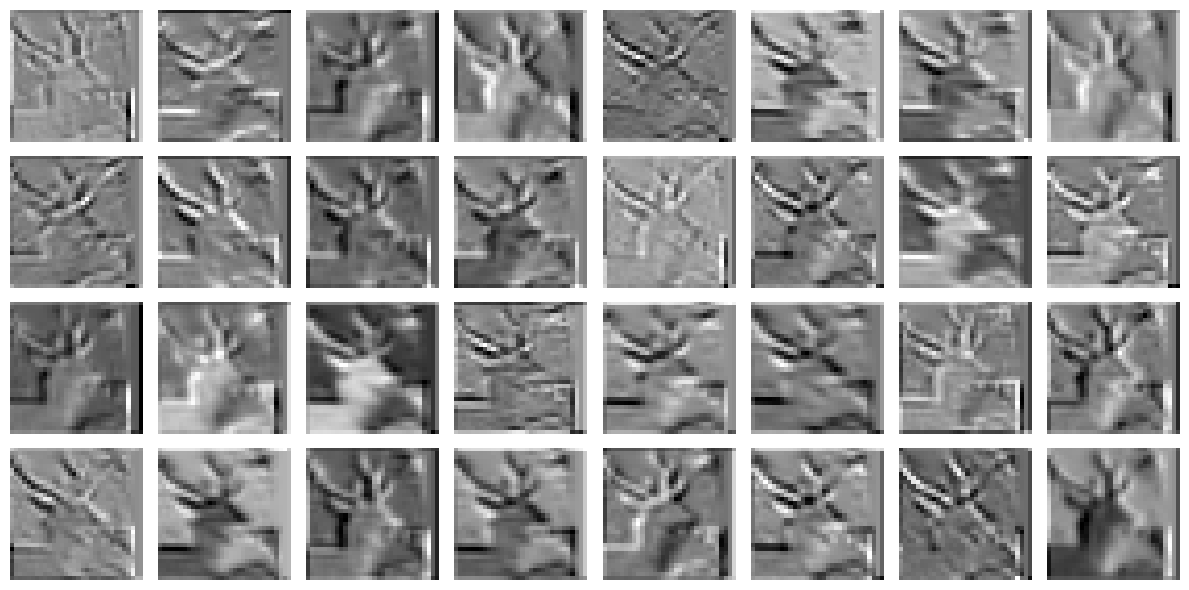

In [ ]:
def get_activation(model, layer, x):
    activation = {}
    def hook_fn(module, input, output):
        activation['output'] = output.detach().cpu()
    hook = layer.register_forward_hook(hook_fn)
    model(x)
    hook.remove()
    return activation['output']

data_iter = iter(trainloader)
sample_images, sample_labels = next(data_iter)
sample_img = sample_images[0].unsqueeze(0)

# Get the feature maps after the first convolution (for example)
activation = get_activation(net, net.conv1, sample_img)

# Visualize a few feature maps in RGB:
def plot_feature_maps(feature_maps, n_cols=8):
    n_features = feature_maps.shape[1]
    n_rows = (n_features + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    for i in range(n_features):
        plt.subplot(n_rows, n_cols, i + 1)
        # Extract the i-th feature map from the first (and only) sample in the batch
        act = feature_maps[0, i, :, :]
        # Normalize the activation map to [0, 1]
        act_norm = (act - act.min()) / (act.max() - act.min() + 1e-8)
        # Repeat the single channel 3 times to form an RGB image
        act_rgb = act_norm.unsqueeze(0).repeat(3, 1, 1)
        plt.imshow(act_rgb.permute(1, 2, 0))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_feature_maps(activation, n_cols=8)

# Play with the index of the chosen sample to notice more patterns and answer the question


# **Theory - Part 2 (20%)**

Please answer the following questions based on your experience/observation during the training and inference of a CNN.

If you find any of these questions challenging or have any doubts, feel free to ask a TA for guidance or hints on the solution.


## 5. Feature Detection
What specific features do you observe in these activation maps? Do some maps clearly highlight edges, contours, or textures? How might these features relate to the overall structure of the sample (e.g., the outline of a horse)?

## Ans5:
The activation maps show the response of each filter in the first convolutional layer to different regions or features in the image. Some maps clearly highlight edges, contours, or textures. These features relate to the overall structure of the sample by detecting edges, corners, and other features that are important for recognizing objects in the image.

## 6. Effect of Training
Consider how the activations might change after training versus an untrained (random) network. What does this tell you about the learning process?

## Ans6:
The activations might change after training by becoming more specialized to detect certain features in the images. This tells us that the learning process involves adjusting the weights of the filters to detect specific features in the images.